In [787]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import sklearn

import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import shap
import joblib


In [788]:
tmp_df = pd.read_csv('../data/VQ_data.csv')
tmp_df['d'] = pd.to_datetime(tmp_df['d'])
tmp_df = tmp_df.set_index(['d', 'insID'])

In [829]:
min_MCAP = 500
clean_df = tmp_df[tmp_df['MCAP']>min_MCAP]
horizon = 6 #what tiem frame are we predicting


monthly_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly_df['log_ret'] = monthly_df['adj_c'].groupby(level='insID').apply(lambda x: np.log(x.shift(- horizon)) - np.log(x))
#monthly_df = monthly_df.unstack('insID').iloc[::horizon, :].stack('insID')

#Take rank of log ret per month values! Ranking forces it into a stationary distribution!!
monthly_df['rank_ret'] = monthly_df['log_ret'].groupby(level='d').rank(ascending=False) #ranked returns


#### CLEAN DATA
colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

#set inf values to max
for col in colmax_list:
    m = monthly_df.loc[monthly_df[col] != np.inf, :].max()
    monthly_df.replace(np.inf,m,inplace=True)


#Invesrt the values that should be low so they should be high
for colmax in colmax_list:
    monthly_df.loc[:, colmax] = (1/monthly_df[colmax])

    
### INDICATOR FUNCTION IF THE COMPANY IS IN FINANCE & RE
monthly_df['sector_ind'] = 0
monthly_df.loc[monthly_df['sector'] == 'finance_RE','sector_ind' ] = 1



Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [830]:
col_list = monthly_df.columns.to_list()

for ele in ['c','number_Of_Shares', '1_day_ret','Name','volatility_60day',
                 'sector','market', 'acceleration', 'adj_mom', 'log_ret','adj_c', 'EA_ret', 'sector_ind']:
    try:
        col_list.remove(ele)
    except:
        print(ele)


col_list1 = col_list.copy()
col_list1.append('rank_ret')

zscore_df = pd.DataFrame()
zscore_df.index = monthly_df.index

for col in col_list1:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly_df[col]
    zscore_tmp_df = zscore_tmp_df.dropna()
    #Rank for each day!! This makes it robust and stationary!! 
    
    # HIGH VALUE GIVES LOW RANK!!!
    zscore_tmp_df = zscore_tmp_df.groupby(level='d').rank(ascending=False)
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)

#group by quintiles 

for col in list(set(list(zscore_df.columns)) - set('rank_ret_zscore')):
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), 10, labels = range(1, 11))
      
#Add indicator function for sector
sector_id_df = pd.DataFrame(monthly_df['sector_ind'])
zscore_df = zscore_df.merge(sector_id_df, on=['d','insID'],how='left')


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [831]:

##############################################    
#combined measures, redo z scores and groups!!
##############################################

zscore_df['comb_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore']
zscore_df['ear_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore']
zscore_df['val_comp'] = zscore_df['PE_zscore'] + zscore_df['PB_zscore'] +zscore_df['EVEBIT_zscore'] +zscore_df['PFCF_zscore']+zscore_df['PS_zscore']
zscore_df['qual_comp'] = zscore_df['GPA_zscore'] + zscore_df['ROIC_zscore'] +zscore_df['ROE_zscore'] + zscore_df['AT_zscore']+zscore_df['FCFROE_zscore'] + zscore_df['Asset_growth_zscore']
zscore_df['ear_mom2'] =  zscore_df['mom6_zscore'] + zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore'] + zscore_df['sharpe_zscore'] 
zscore_df['ear_mom3'] =  zscore_df['mom6_zscore'] + zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore'] + zscore_df['sharpe_zscore'] + zscore_df['res_mom12_zscore']




## REDO ZSCORE AND QUANTILES FOR COMBINED MEASURES

for col in ['comb_mom', 'ear_mom', 'val_comp', 'qual_comp', 'ear_mom2', 'ear_mom3']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['comb_mom_zscore', 'ear_mom_zscore', 'val_comp_zscore', 'qual_comp_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), 10, labels = range(1, 11))

##############################################    
######### REDO FOR COMBINATION OF COMBINATIONS, VMQ, QM, VQ, VM
#################################################

zscore_df['VMQ'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['MQ'] = zscore_df['ear_mom_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VQ'] =  zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VM'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore']

## REDO ZSCORE AND QUANTILES FOR COMBINED OF COMBINED MEASURES

for col in ['VMQ', 'MQ', 'VQ', 'VM']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['VMQ_zscore', 'MQ_zscore', 'VQ_zscore', 'VM_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), 10, labels = range(1, 11))


    
full_df_tmp = zscore_df.copy()
zscore_df = zscore_df.unstack('insID').iloc[::horizon, :].stack('insID')

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

In [1031]:
model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)
        

coeff_list_full = model_list.copy()

remv_list = ['rank_ret_zscore', 'ear_mom_zscore', 'val_comp_zscore','qual_comp_zscore', 'comb_mom_zscore',
            'MQ_zscore', 'VM_zscore', 'VQ_zscore', 'VMQ_zscore',
             'mom1_zscore', 'ROE_chg_zscore',
             'rev_growth_zscore','EPS_growth_zscore','EPS_acceleration_zscore','MA50_VOL_zscore']

for ele in remv_list:
    coeff_list_full.remove(ele)
        
        
coeff_list_comp = ['ear_mom_zscore','val_comp_zscore','qual_comp_zscore']


coeff_list_mom = ['EAR_std_zscore','mom12_zscore', 'mom6_zscore','res_mom12_zscore', 'high_12m_zscore','high_6m_zscore','high_3y_zscore']

coeff_list_val = ['EVEBIT_zscore','Asset_growth_zscore', 'PS_zscore',
                  'PB_zscore', 'PE_zscore']

coeff_list_qual = ['ROIC_zscore','ROE_zscore','GPA_zscore','AT_zscore', 'ROA_zscore',
                  'FCFROE_zscore','PO_zscore','FCF_Assets_zscore']

coeff_list_misc = ['skew_zscore', 'volatility_zscore', 'RSURP_Y_zscore','SUE_Y_zscore', 'beta_zscore']

coeff_list_multi = ['EAR_std_zscore','mom12_zscore', 'mom6_zscore','high_12m_zscore','EMA_96_288_zscore',
                    'EVEBIT_zscore', 'PS_zscore','PB_zscore', 'PE_zscore', 'PO_zscore',
                  'ROIC_zscore','ROE_zscore','GPA_zscore','AT_zscore', 'ROA_zscore']

coeff_list =coeff_list_mom + coeff_list_val + coeff_list_qual  #['MA_200_zscore', 'mom12_zscore', 'high_12m_zscore','EAR_std_zscore','EMA_96_288_zscore',
            #'sharpe_zscore']



In [1032]:
coeff_list_full

['MCAP_zscore',
 'PE_zscore',
 'GPA_zscore',
 'GPA_chg_zscore',
 'Asset_growth_zscore',
 'PB_zscore',
 'EAR_std_zscore',
 'AVG_EAR_zscore',
 'EVEBIT_zscore',
 'EVFCF_zscore',
 'ROIC_zscore',
 'ROE_zscore',
 'AT_zscore',
 'RSURP_Y_zscore',
 'SUE_Y_zscore',
 'mom12_zscore',
 'mom6_zscore',
 'mom3_zscore',
 'volatility_zscore',
 'sharpe_zscore',
 'sharpe_6m_zscore',
 'high_12m_zscore',
 'high_6m_zscore',
 'high_3m_zscore',
 'high_1m_zscore',
 'high_2y_zscore',
 'high_3y_zscore',
 'high_4y_zscore',
 'low_1m_zscore',
 'low_3m_zscore',
 'low_6m_zscore',
 'low_12m_zscore',
 'low_2y_zscore',
 'skew_zscore',
 'EMA_32_96_zscore',
 'EMA_96_288_zscore',
 'range_2y_zscore',
 'range_12m_zscore',
 'range_6m_zscore',
 'range_3m_zscore',
 'range_1m_zscore',
 'VAR_1_zscore',
 'MA_200_zscore',
 'FCFROE_zscore',
 'FCF_Assets_zscore',
 'ROA_zscore',
 'PS_zscore',
 'PFCF_zscore',
 'DIV_Y_zscore',
 'res_mom12_zscore',
 'Gross_margin_zscore',
 'beta_zscore',
 'alpha_zscore',
 'std_alpha_zscore',
 'ido_mom12_z

## Train Model

In [1033]:
np.random.seed(123)
train_ratio = 0.99#0.7

reg_df = zscore_df[coeff_list + ['rank_ret_zscore']].dropna()



eval_train_df = reg_df[:int(len(reg_df)*train_ratio)]
eval_test_df =  reg_df[int(len(reg_df)*(1-train_ratio)):]

X_ml = reg_df[coeff_list]
Y_ml = pd.DataFrame(reg_df[['rank_ret_zscore']])

#splitting data into train and test
X_train = X_ml[:int(len(X_ml)*train_ratio)]
X_test = X_ml[int(len(X_ml)*(1-train_ratio)):]
Y_train = Y_ml[:int(len(X_ml)*(train_ratio))]
Y_test = Y_ml[int(len(X_ml)*(1-train_ratio)):]

#creating dmatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [1034]:
## TUNE WITH GRIDSEARCH

from sklearn.ensemble import RandomForestRegressor

param_grid =  {'n_estimators': [ 600],
               'max_features': ['auto'],
               'max_depth' : [1],
               'min_samples_split': [2],
               'min_samples_leaf': [2],
               'bootstrap': [True]}


rfc=RandomForestRegressor(random_state=20)
clf_rf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

clf_rf.fit(X_train, Y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20),
             param_grid={'bootstrap': [True], 'max_depth': [1],
                         'max_features': ['auto'], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [600]})

In [1035]:
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 1,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE for train set:  0.9837327884751802


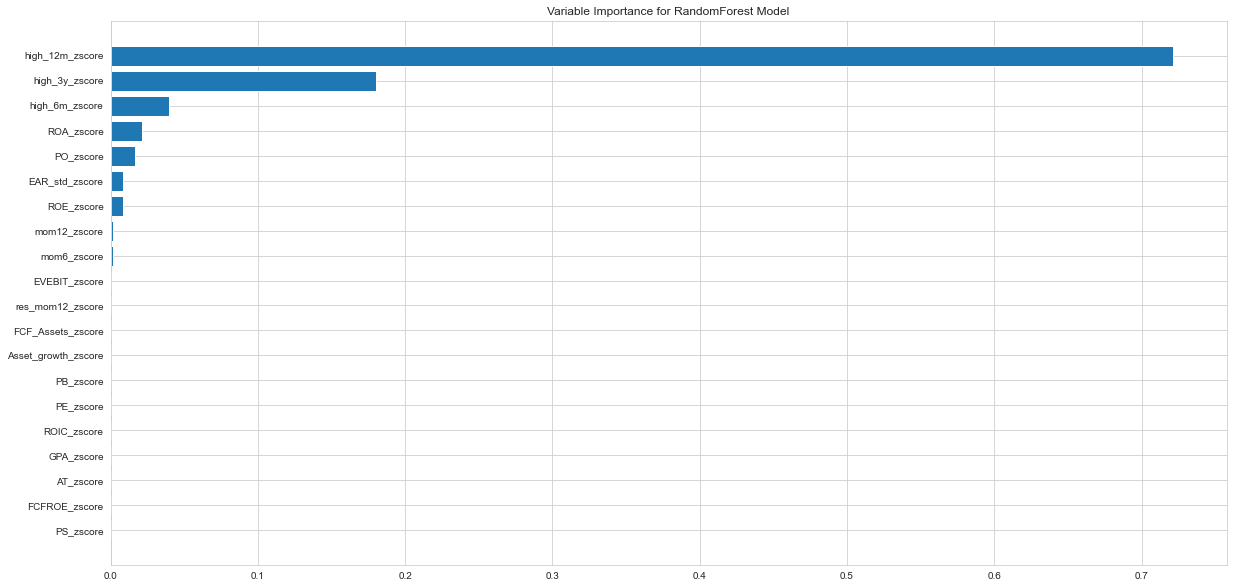

In [1036]:
eval_train_df.loc[:, 'pred_y'] = clf_rf.predict(X_train)
MSE_train = np.mean((eval_train_df['rank_ret_zscore'] - eval_train_df['pred_y'])**2)

print("MSE for train set: ", MSE_train)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval_train_df.loc[:, col_group] = pd.qcut(eval_train_df[col].rank(method='first'), 10, labels = range(1, 11))
        

VIP_RF_df = pd.DataFrame(clf_rf.best_estimator_.feature_importances_, index = X_train.columns).sort_values(0, ascending=True)    
plt.figure(figsize=(20,10));
plt.barh(VIP_RF_df.transpose().columns,VIP_RF_df.iloc[:, 0]);
plt.title('Variable Importance for RandomForest Model');

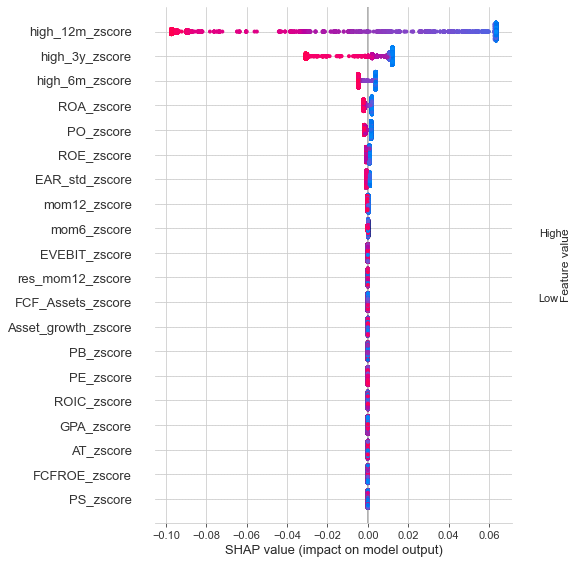

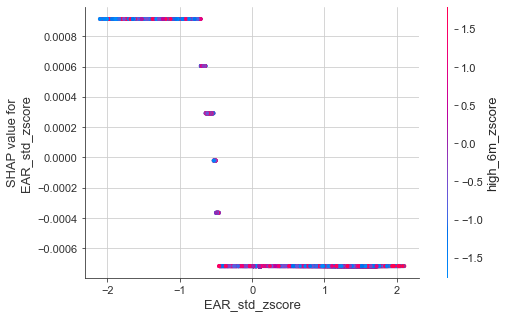

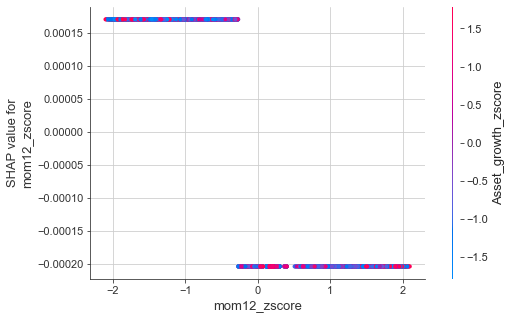

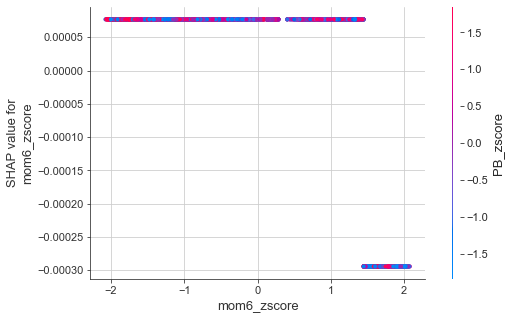

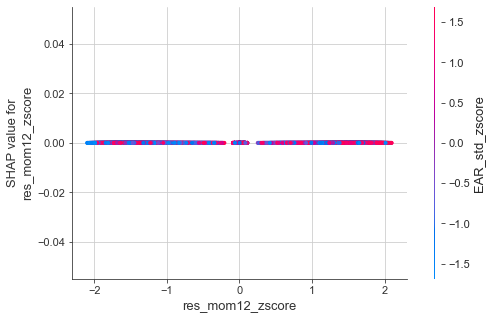

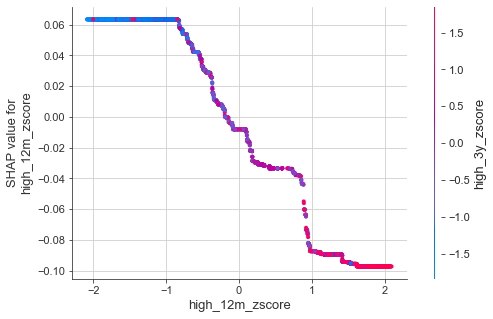

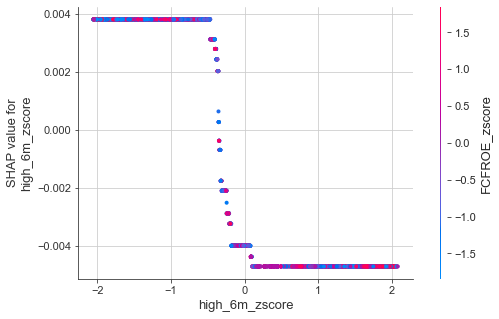

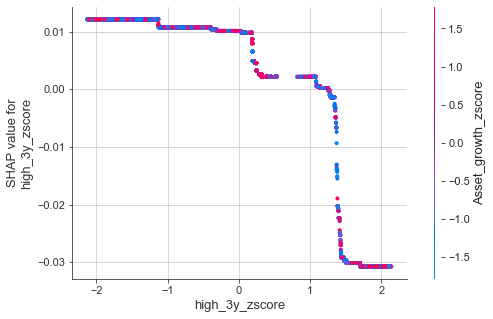

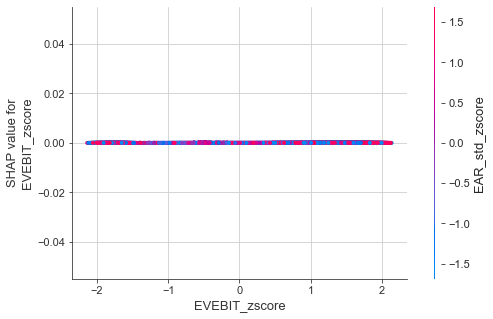

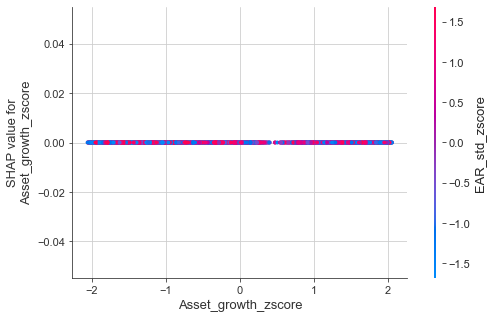

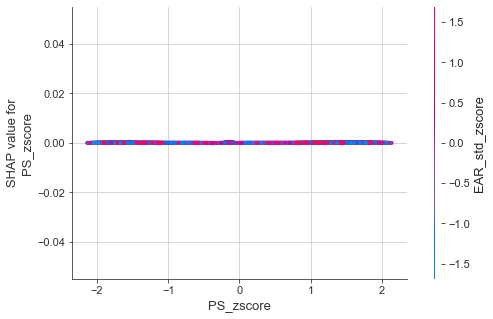

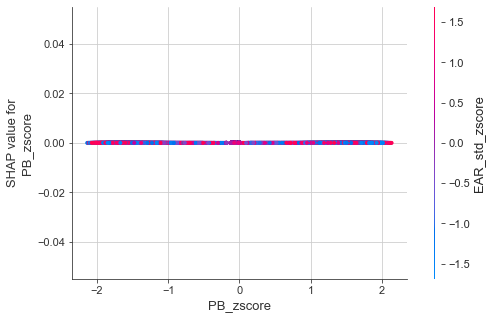

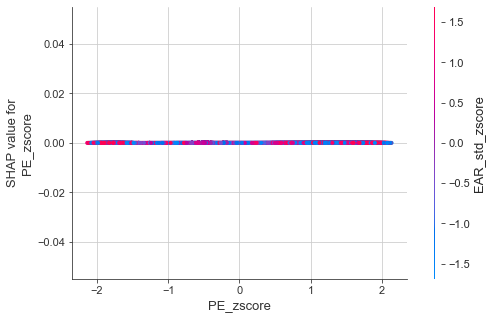

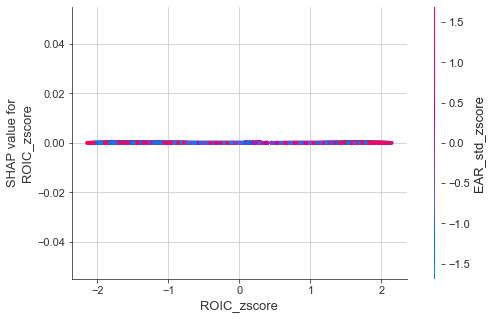

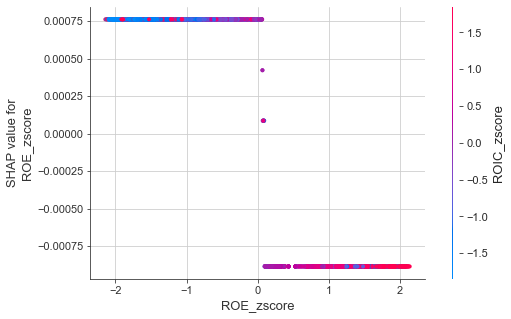

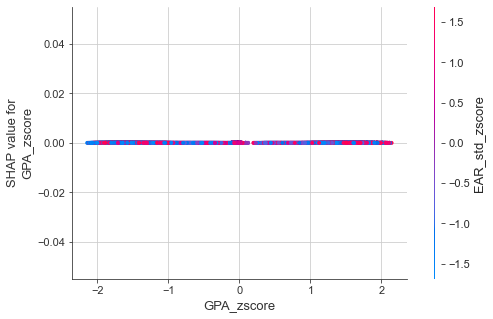

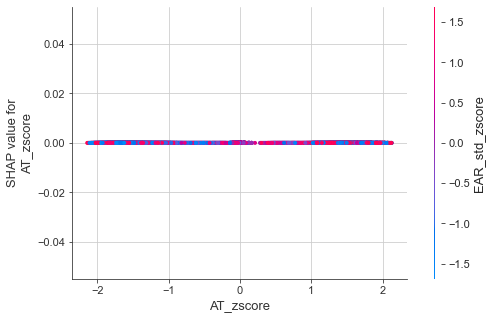

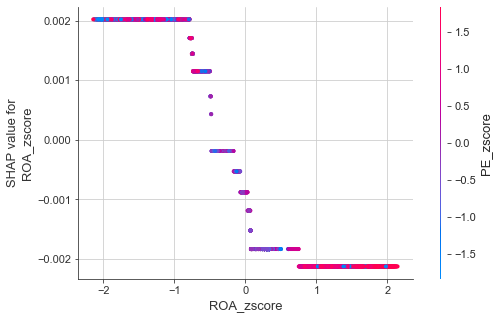

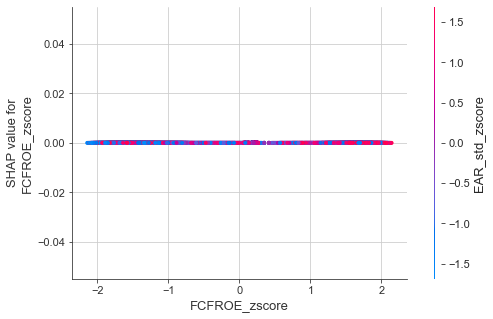

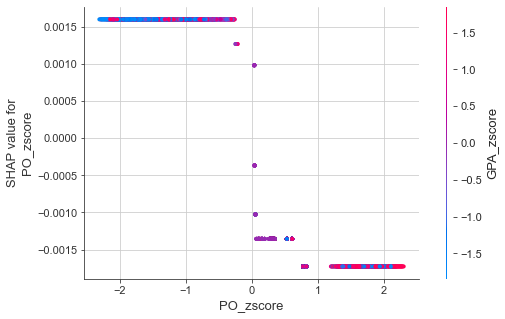

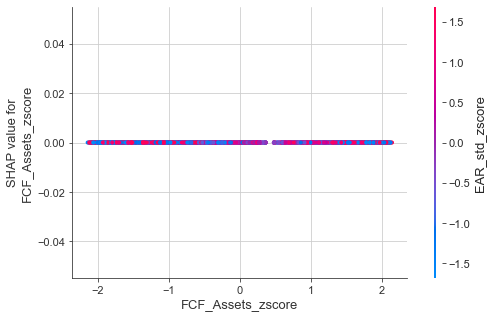

In [1037]:
shap_values_ind_rf = shap.TreeExplainer(clf_rf.best_estimator_).shap_values(X_ml)

shap.summary_plot(shap_values_ind_rf,X_ml)
for var in coeff_list:
    shap.dependence_plot(var, shap_values_ind_rf, X_ml )#interaction_index=None

In [1038]:
VIP_rank = pd.DataFrame(VIP_RF_df.iloc[:, 0])
VIP_rank.columns = ['VIP']
VIP_rank.sort_values(by=['VIP'],ascending=False,inplace=True)
VIP_rank

,VIP
high_12m_zscore,0.721667
high_3y_zscore,0.180000
high_6m_zscore,0.040000
ROA_zscore,0.021667
PO_zscore,0.016667
EAR_std_zscore,0.008333
ROE_zscore,0.008333
mom12_zscore,0.001667
mom6_zscore,0.001667
FCFROE_zscore,0.000000


In [1039]:
#Rank by Shap Values
vals= np.abs(shap_values_ind_rf).mean(0)
vals = vals / vals.sum() #Normalize
feature_importance = pd.DataFrame(vals, index = X_ml.columns,columns=['VIP_SHAP'])
feature_importance.sort_values(by=['VIP_SHAP'],ascending=False,inplace=True)
feature_importance

,VIP_SHAP
high_12m_zscore,0.736196
high_3y_zscore,0.156705
high_6m_zscore,0.046242
ROA_zscore,0.021604
PO_zscore,0.017714
ROE_zscore,0.009196
EAR_std_zscore,0.008879
mom12_zscore,0.002095
mom6_zscore,0.001371
FCFROE_zscore,0.000000


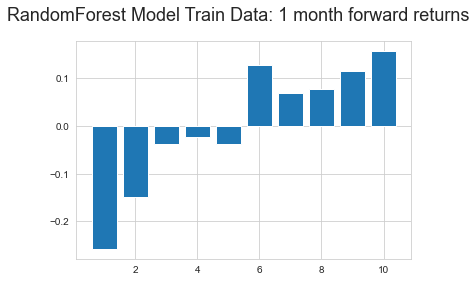

In [1040]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('RandomForest Model Train Data: 1 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval_train_df.groupby("pred_y_group").mean()['rank_ret_zscore']);
ax.set_title('');

# EVAL

In [1024]:
eval_test_df.loc[:, 'pred_y'] = clf_rf.predict(X_test)
MSE_test = np.mean((eval_test_df['rank_ret_zscore'] - eval_test_df['pred_y'])**2)

print("MSE for test set: ", MSE_test)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval_test_df.loc[:, col_group] = pd.qcut(eval_test_df[col].rank(method='first'), 10, labels = range(1, 11))

MSE for test set:  0.9875231071723711



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


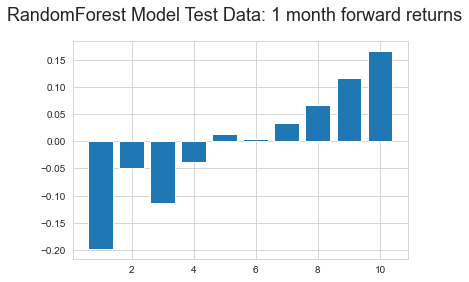

In [1025]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('RandomForest Model Test Data: 1 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval_test_df.groupby("pred_y_group").mean()['rank_ret_zscore']);
ax.set_title('');

In [1026]:
X_ml.corr(method = 'spearman')

,ear_mom_zscore,val_comp_zscore,qual_comp_zscore
ear_mom_zscore,1.000000,-0.153220,0.058366
val_comp_zscore,-0.153220,1.000000,0.010735
qual_comp_zscore,0.058366,0.010735,1.000000


In [1027]:
X_ml.groupby(level='insID').diff(horizon).abs().mean()

ear_mom_zscore      1.566135
val_comp_zscore     0.841208
qual_comp_zscore    0.878787
dtype: float64

In [1028]:
### Clustring 

import scipy.cluster.hierarchy as spc

corr = X_ml[coeff_list].corr(method = 'spearman').values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
#idx = spc.fcluster(linkage, 3, 'maxclust')

CLUSTERS = pd.DataFrame(idx)
CLUSTERS.index = coeff_list

In [1029]:
CLUSTERS

,0
ear_mom_zscore,1
val_comp_zscore,3
qual_comp_zscore,2


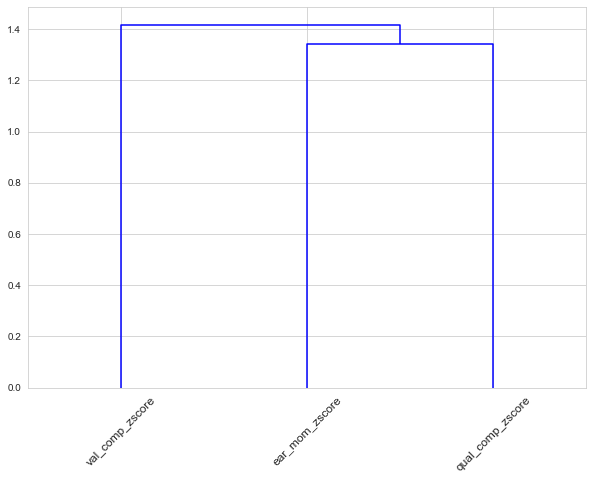

In [1030]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(corr, 'single')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=coeff_list,
            distance_sort='descending',
            show_leaf_counts=True, leaf_rotation = 45)
plt.show()

### Retrive singel tree

In [908]:
from sklearn import tree
#tree.plot_tree(clf_rf.best_estimator_.estimators_[1], feature_names=X_train.columns);

## Export results

In [909]:
## Export predicited values to backtest dev
full_df_tmp = full_df_tmp.sort_index(level=0)
pred_df = full_df_tmp.loc[full_df_tmp['mom12_zscore'].first_valid_index():,]

export_df = pred_df.copy()
pred_df.loc[:, coeff_list] = pred_df[coeff_list].fillna(0)

export_df.loc[:,'RF_pred'] = clf_rf.predict(pred_df[coeff_list])
export_df = pd.DataFrame(export_df['RF_pred'])

export_df.to_csv("RF_pred.csv")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
